In [1]:
import random
random.seed(123)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
import math
import time
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import fbeta_score
#import plotting stuff
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pylab as pylab

In [2]:
params = {'legend.fontsize': 'large',
          #'figure.figsize': (15,5),
          #'axes.grid' :True,
          #'grid.color' :'White',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'lines.linewidth':1}
pylab.rcParams.update(params)
sns.set_style("whitegrid")


### Part 1: Data Pre-processing

In [3]:
df = pd.read_csv("../resources/data/nyc-taxi/nyc_taxi.csv", header=None, names=['timestamp', 'rides'])

In [4]:
print("Data Range")
print("Start Date %s"%(df.head(1)['timestamp']))
print("End Date %s"%(df.tail(1)['timestamp']))

Data Range
Start Date 0    7/1/14 0:00
Name: timestamp, dtype: object
End Date 10319    1/31/15 23:30
Name: timestamp, dtype: object


In [5]:
print("num_values: %s"%(df.shape[0]))

num_values: 10320


In [7]:
class SetColAsIndex(TransformerMixin):
    def __init__(self, col):
        self.col = col

    def transform(self, X, **transform_params):
        X.index = X.loc[:, self.col].apply(lambda x: pd.to_datetime(x))
        return X

    def fit(self, X, y=None, **fit_params):
        return self


class FilterCompleteDays(TransformerMixin):
    def __init__(self, n=96):
        self.n = n

    def transform(self, X, **transform_params):
        #print X.groupby(X.index.date).transform('count')
        X = X.ix[X.groupby(X.index.date).transform('count').iloc[:, 0] >= self.n]
        return X

    def fit(self, X, y=None, **fit_params):
        return self

class FilterDays(TransformerMixin):
    def __init__(self, days=None):
        self.days = days

    def transform(self, X, **transform_params):
        X = X.iloc[pd.Series(X.index.day).isin(self.days).values, :]
        return X

    def fit(self, X, y=None, **fit_params):
        return self


class FilterWeekEnd(TransformerMixin):
    def transform(self, X, **transform_params):
        X = X[X.index.weekday > 4]
        return X

    def fit(self, X, y=None, **fit_params):
        return self


class SortTimeSeries(TransformerMixin):
    def transform(self, X, **transform_params):
        X = X.sort_index()
        return X

    def fit(self, X, y=None, **fit_params):
        return self


class RemoveDuplicateRow(TransformerMixin):
    def __init__(self, sample_period):
        self.sample_period = sample_period

    def transform(self, X, **transform_params):
        X = X.resample(self.sample_period, 'mean').fillna(method='bfill')
        return X

    def fit(self, X, y=None, **fit_params):
        return self

In [8]:
process_pipeline = make_pipeline(SetColAsIndex('timestamp'),
                                SortTimeSeries())
df = process_pipeline.fit_transform(df)
df = df.drop('timestamp', 1)
# df['year']=df.index.year
# df['month']=df.index.month
# df['weekday_name']=df.index.weekday_name
# df['hour']=df.index.hour

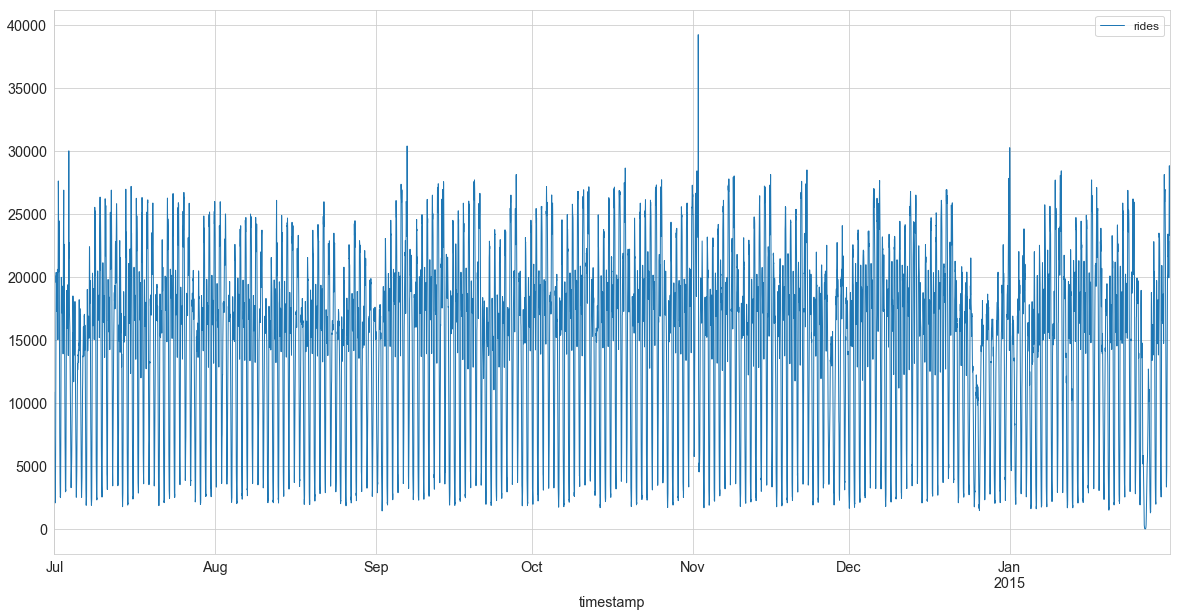

In [9]:
df.plot(figsize=(20,10))
plt.show()

In [10]:
df.head()

rides
timestamp                 
2014-07-01 00:00:00  10844
2014-07-01 00:30:00   8127
2014-07-01 01:00:00   6210
2014-07-01 01:30:00   4656
2014-07-01 02:00:00   3820

In [11]:
df.tail()

rides
timestamp                 
2015-01-31 21:30:00  24670
2015-01-31 22:00:00  25721
2015-01-31 22:30:00  27309
2015-01-31 23:00:00  26591
2015-01-31 23:30:00  26288

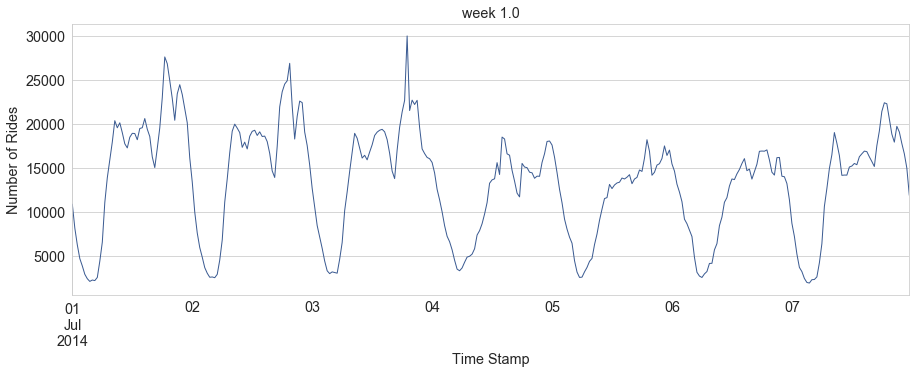

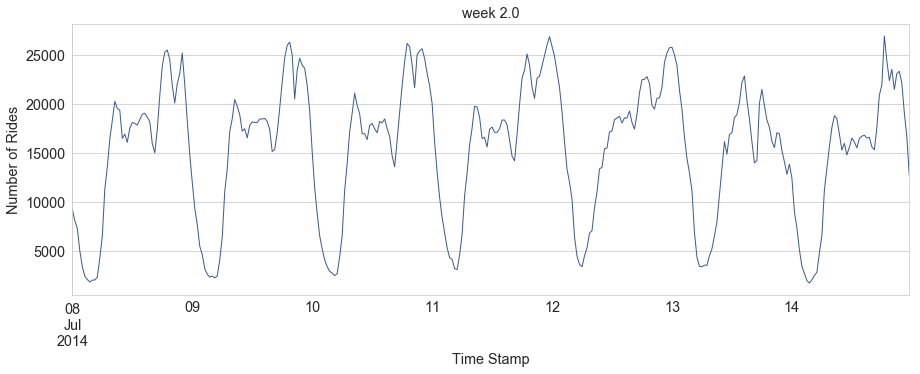

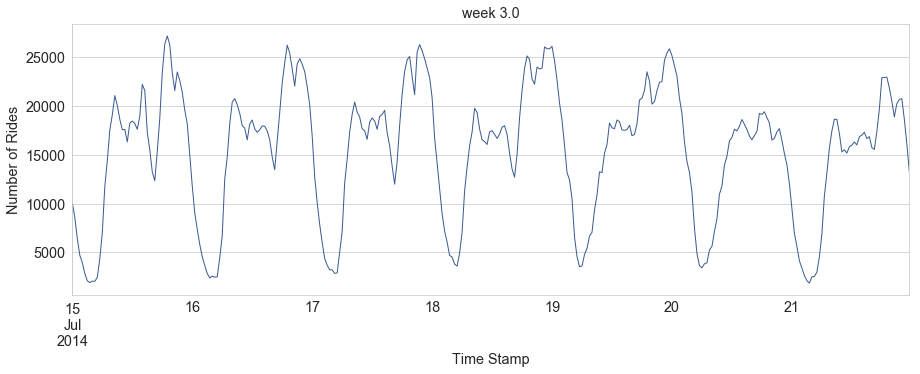

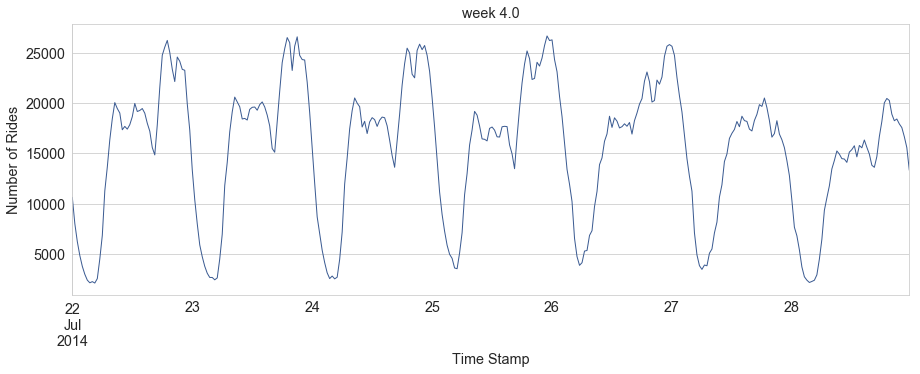

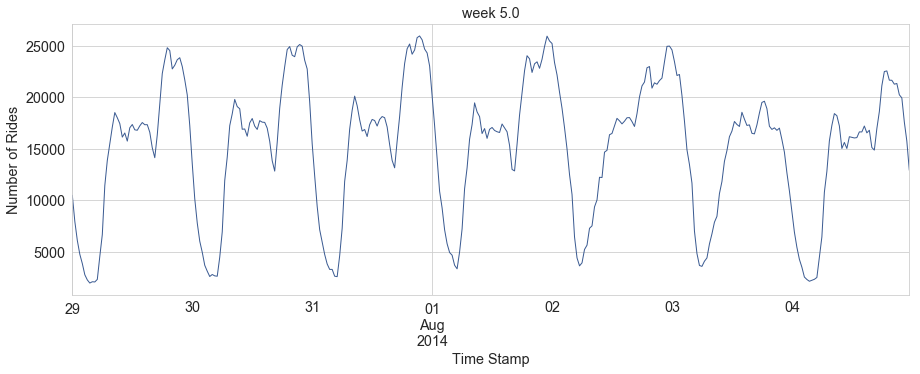

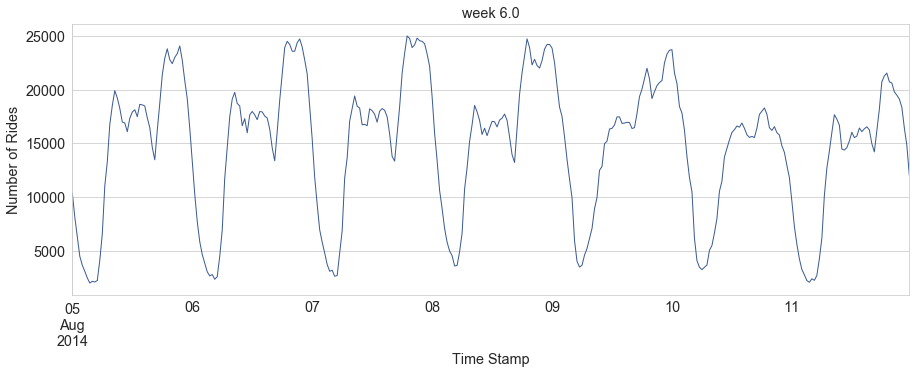

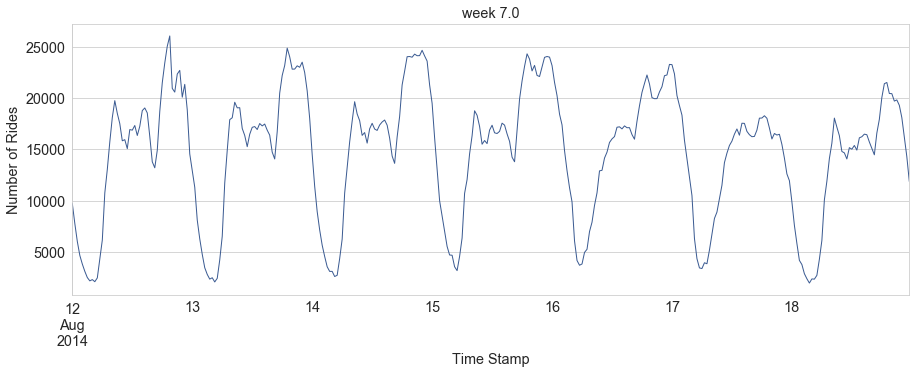

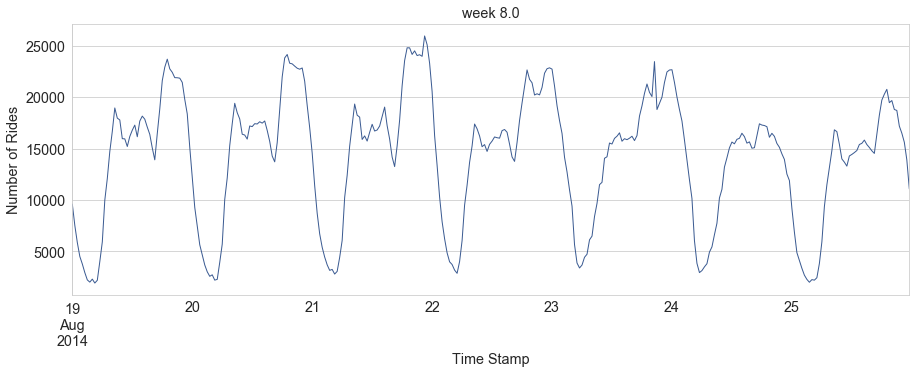

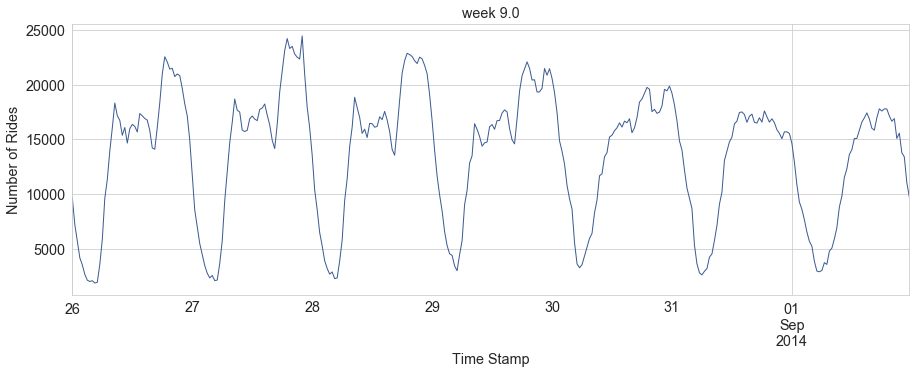

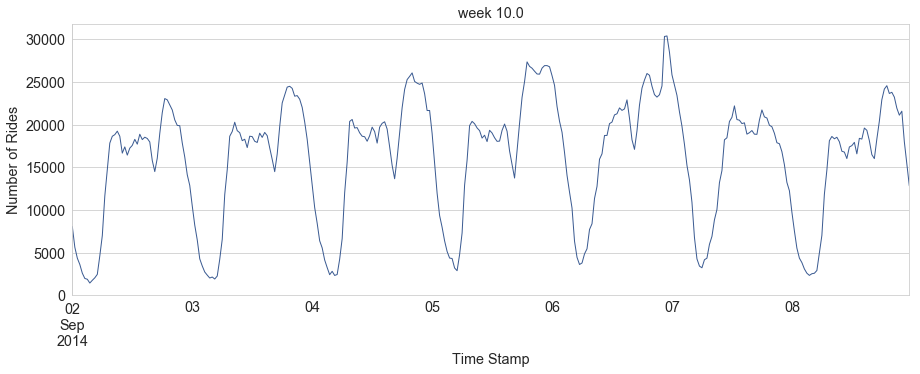

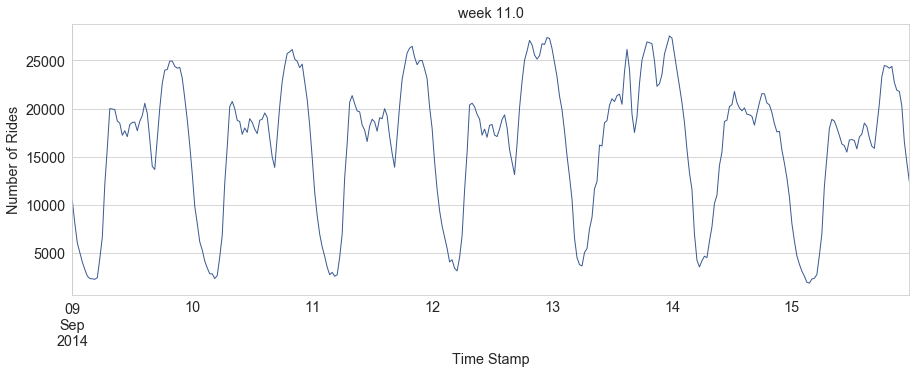

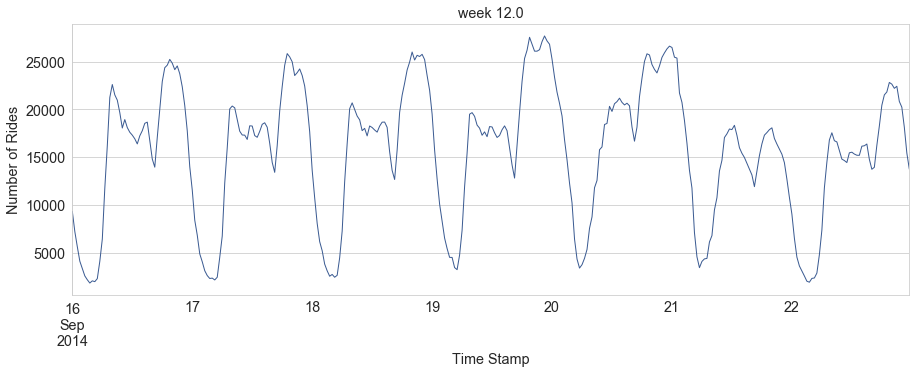

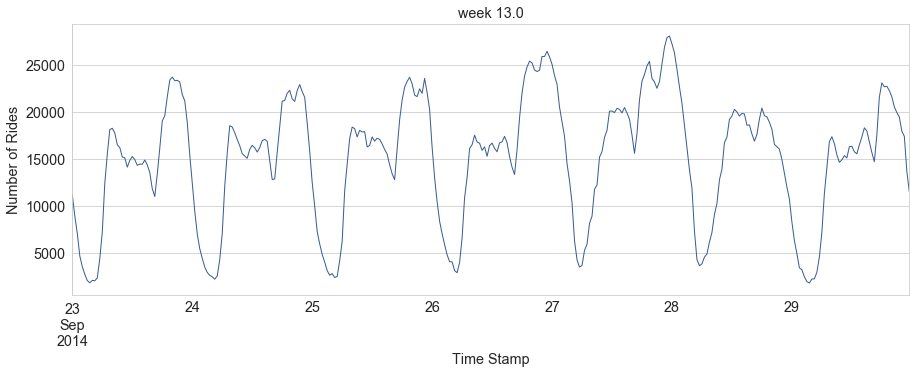

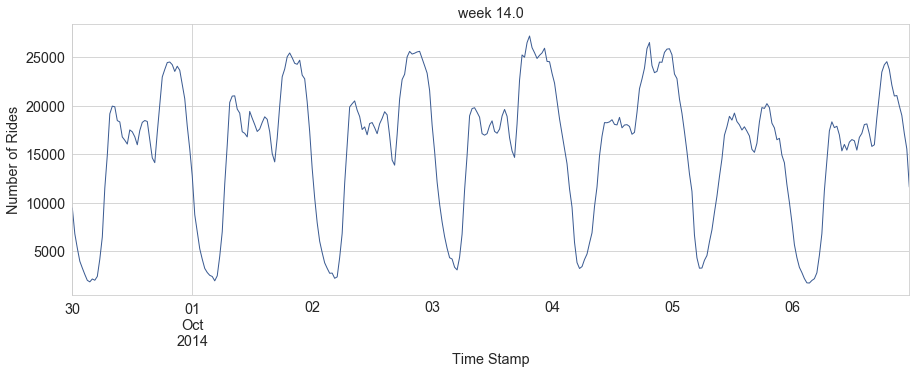

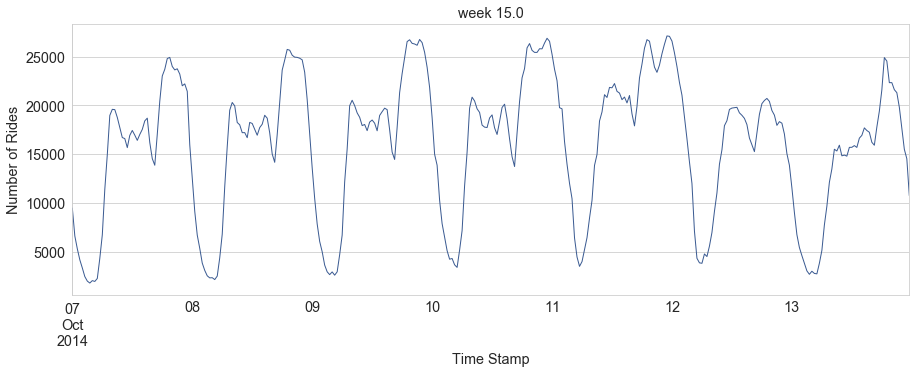

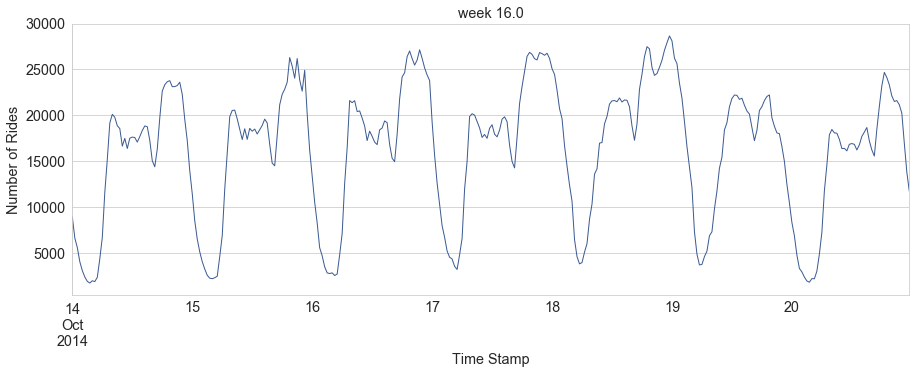

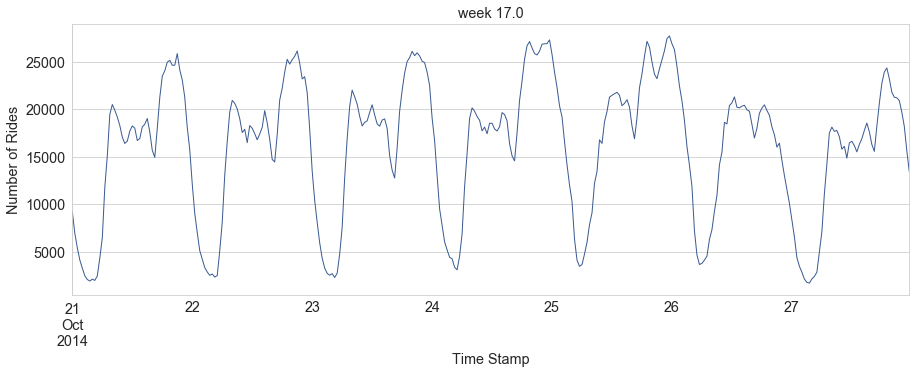

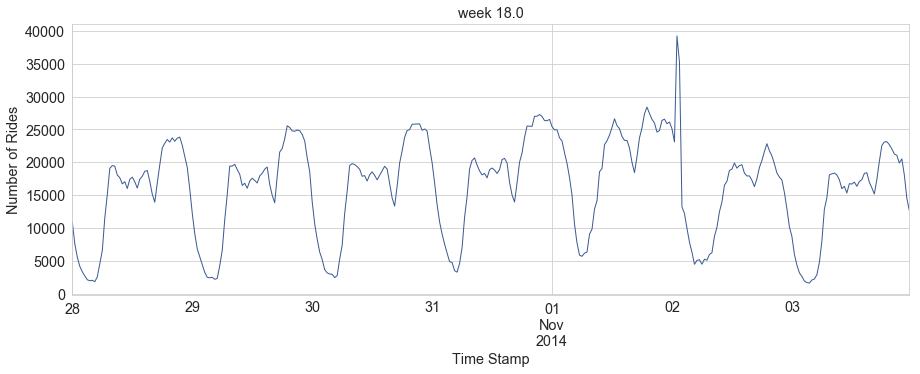

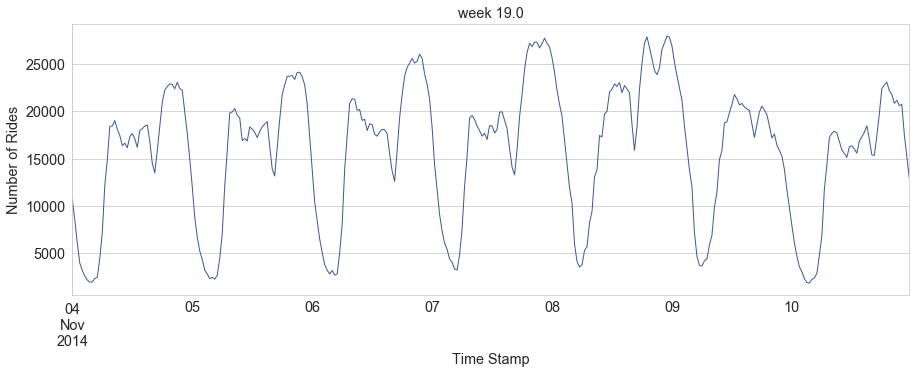

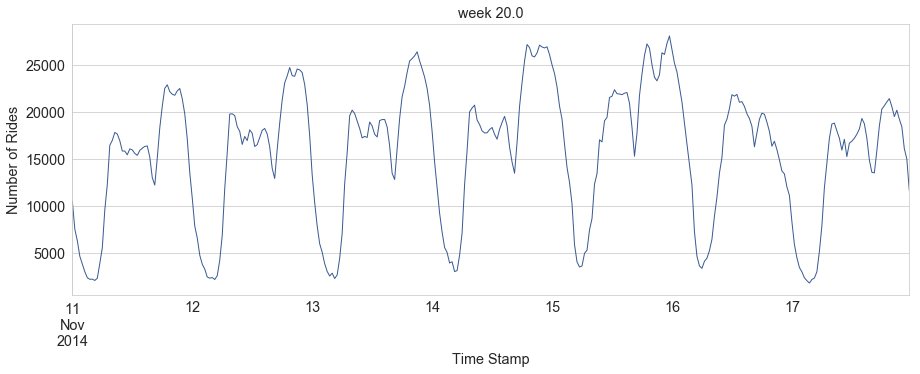

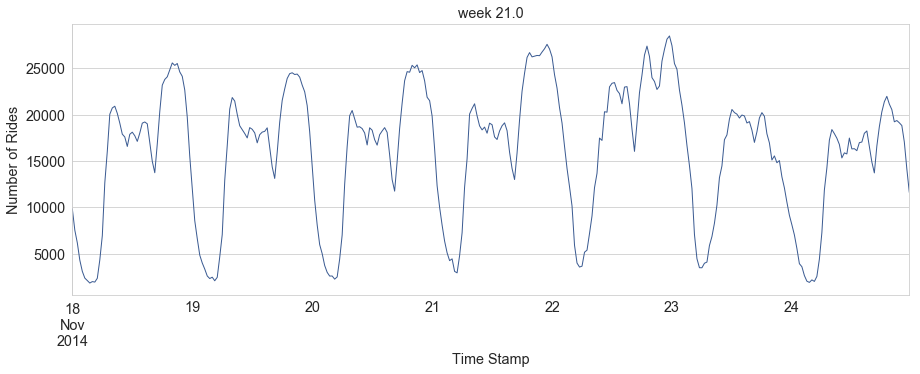

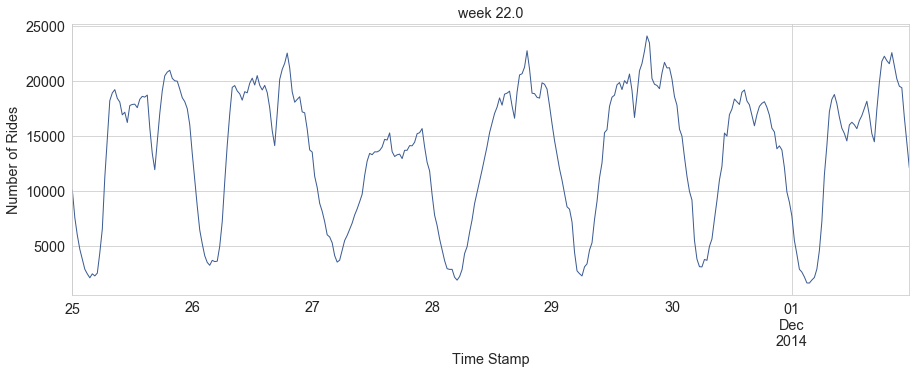

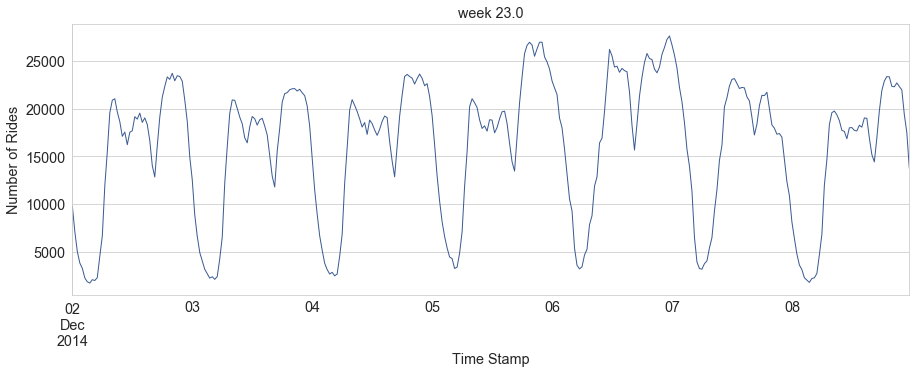

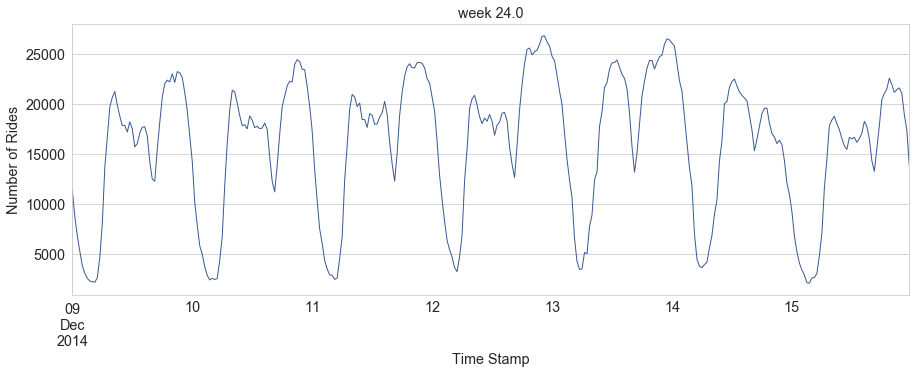

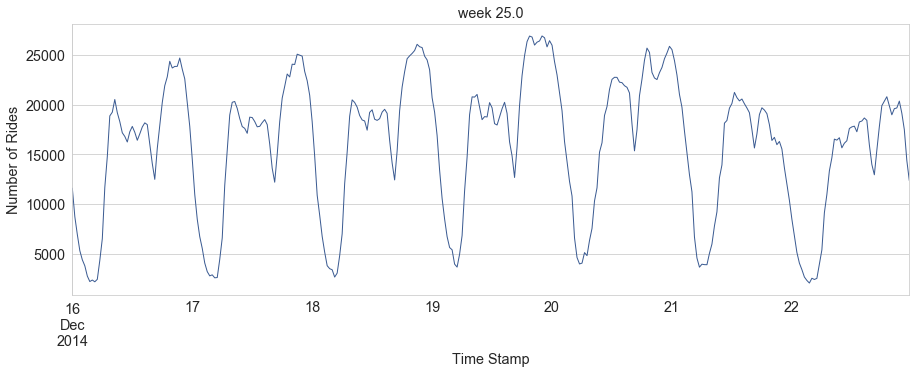

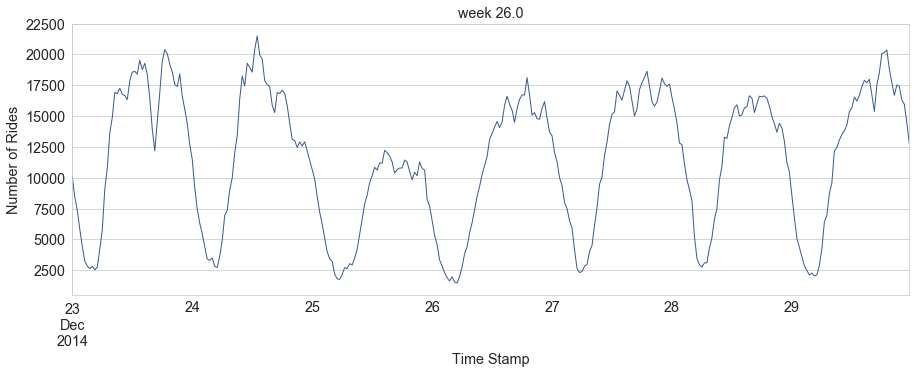

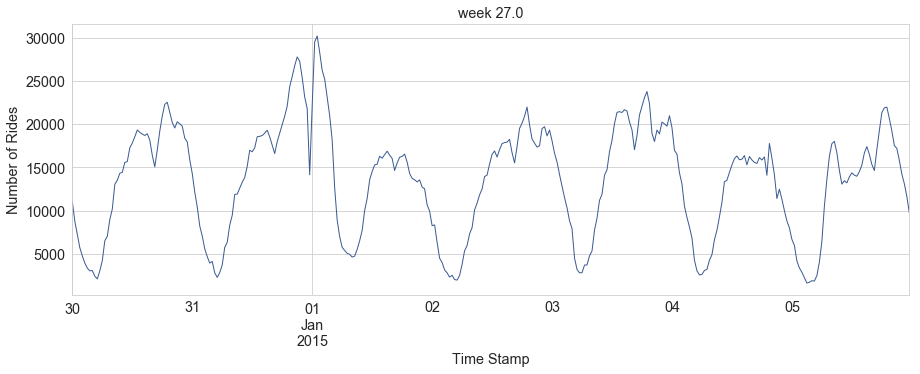

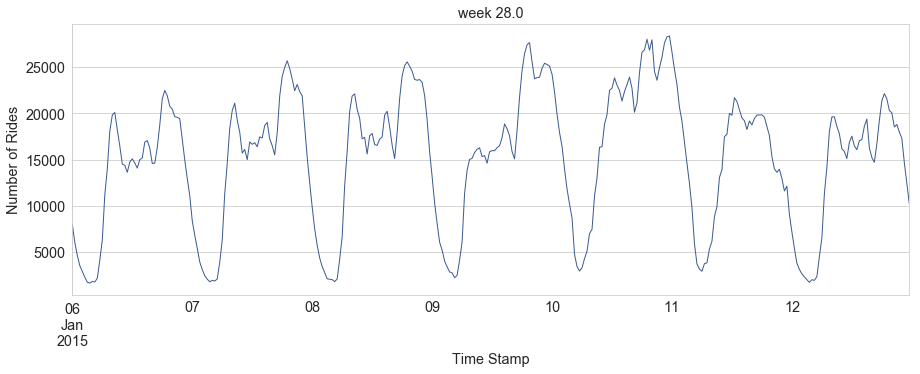

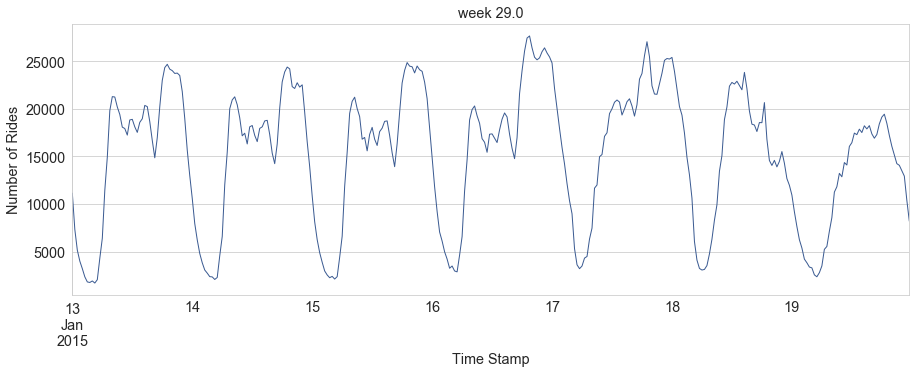

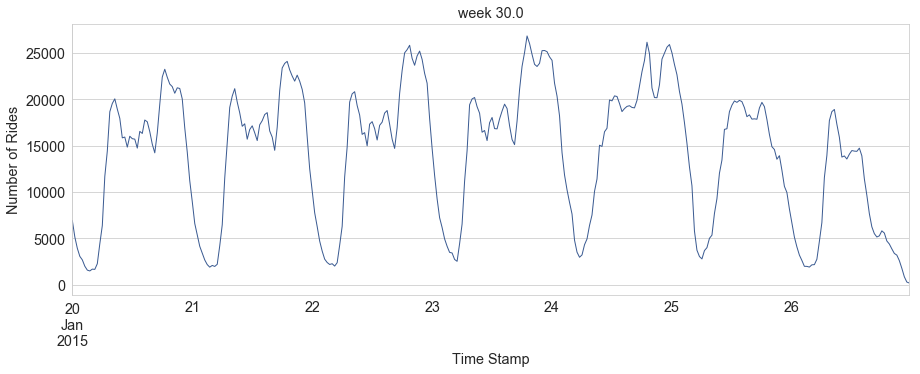

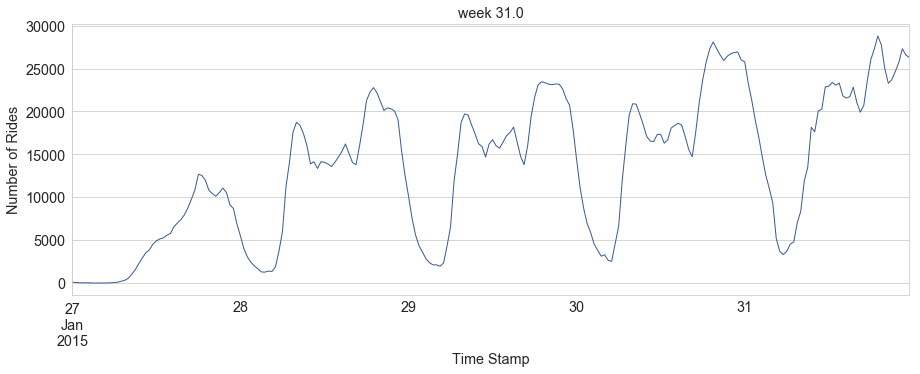

In [12]:
step = int(60 * 24 * 7 / 30)

for i in range(0,df.shape[0],step):
    fig = plt.figure(figsize=(15,5))
    tmp = df[i:i+step]['rides'].plot(color=sns.xkcd_rgb["denim blue"])
    plt.title("week %s"%(i/step +1))
    plt.xlabel('Time Stamp')
    plt.ylabel('Number of Rides')
    plt.show()
    pp = PdfPages("number_of_rides_%s.pdf"%(i/step +1))
    pp.savefig(fig)
    pp.close()

In [14]:
#add anomaly column
df['anomaly'] = 0
anomalies = ["2015-01-27 00:00:00","2015-01-01 01:00:00","2014-11-27 15:30:00","2014-11-02 01:00:00"]
anomalies = ["2014-07-03 19:00:00", "2014-09-06 22:30:00", "2014-09-06 23:00:00", "2014-11-02 01:00:00", "2014-11-02 01:30:00", "2015-01-01 00:30:00", "2015-01-01 01:00:00", "2015-01-26 22:30:00", "2015-01-26 23:00:00", "2015-01-26 23:30:00", "2015-01-27 00:00:00", "2015-01-27 00:30:00", "2015-01-27 01:00:00", "2015-01-27 01:30:00", "2015-01-27 02:00:00", "2015-01-27 02:30:00", "2015-01-27 03:00:00", "2015-01-27 03:30:00", "2015-01-27 04:00:00", "2015-01-27 04:30:00", "2015-01-27 05:00:00", "2015-01-27 05:30:00", "2015-01-27 06:00:00", "2015-01-27 06:30:00", "2015-01-27 07:00:00", "2015-01-27 07:30:00", "2015-01-27 08:00:00", "2015-01-27 08:30:00"]
for anomaly_date in anomalies:
    df.set_value(anomaly_date,'anomaly', 1)
rows = df[df.anomaly.isin([1])].itertuples()
for row in rows:
    print(row[0],row[1],row[2])

2014-07-03 19:00:00 29985 1
2014-09-06 22:30:00 30313 1
2014-09-06 23:00:00 30373 1
2014-11-02 01:00:00 39197 1
2014-11-02 01:30:00 35212 1
2015-01-01 00:30:00 29547 1
2015-01-01 01:00:00 30236 1
2015-01-26 22:30:00 866 1
2015-01-26 23:00:00 297 1
2015-01-26 23:30:00 189 1
2015-01-27 00:00:00 109 1
2015-01-27 00:30:00 80 1
2015-01-27 01:00:00 40 1
2015-01-27 01:30:00 39 1
2015-01-27 02:00:00 26 1
2015-01-27 02:30:00 32 1
2015-01-27 03:00:00 8 1
2015-01-27 03:30:00 11 1
2015-01-27 04:00:00 9 1
2015-01-27 04:30:00 20 1
2015-01-27 05:00:00 21 1
2015-01-27 05:30:00 37 1
2015-01-27 06:00:00 69 1
2015-01-27 06:30:00 107 1
2015-01-27 07:00:00 216 1
2015-01-27 07:30:00 332 1
2015-01-27 08:00:00 570 1
2015-01-27 08:30:00 1049 1


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


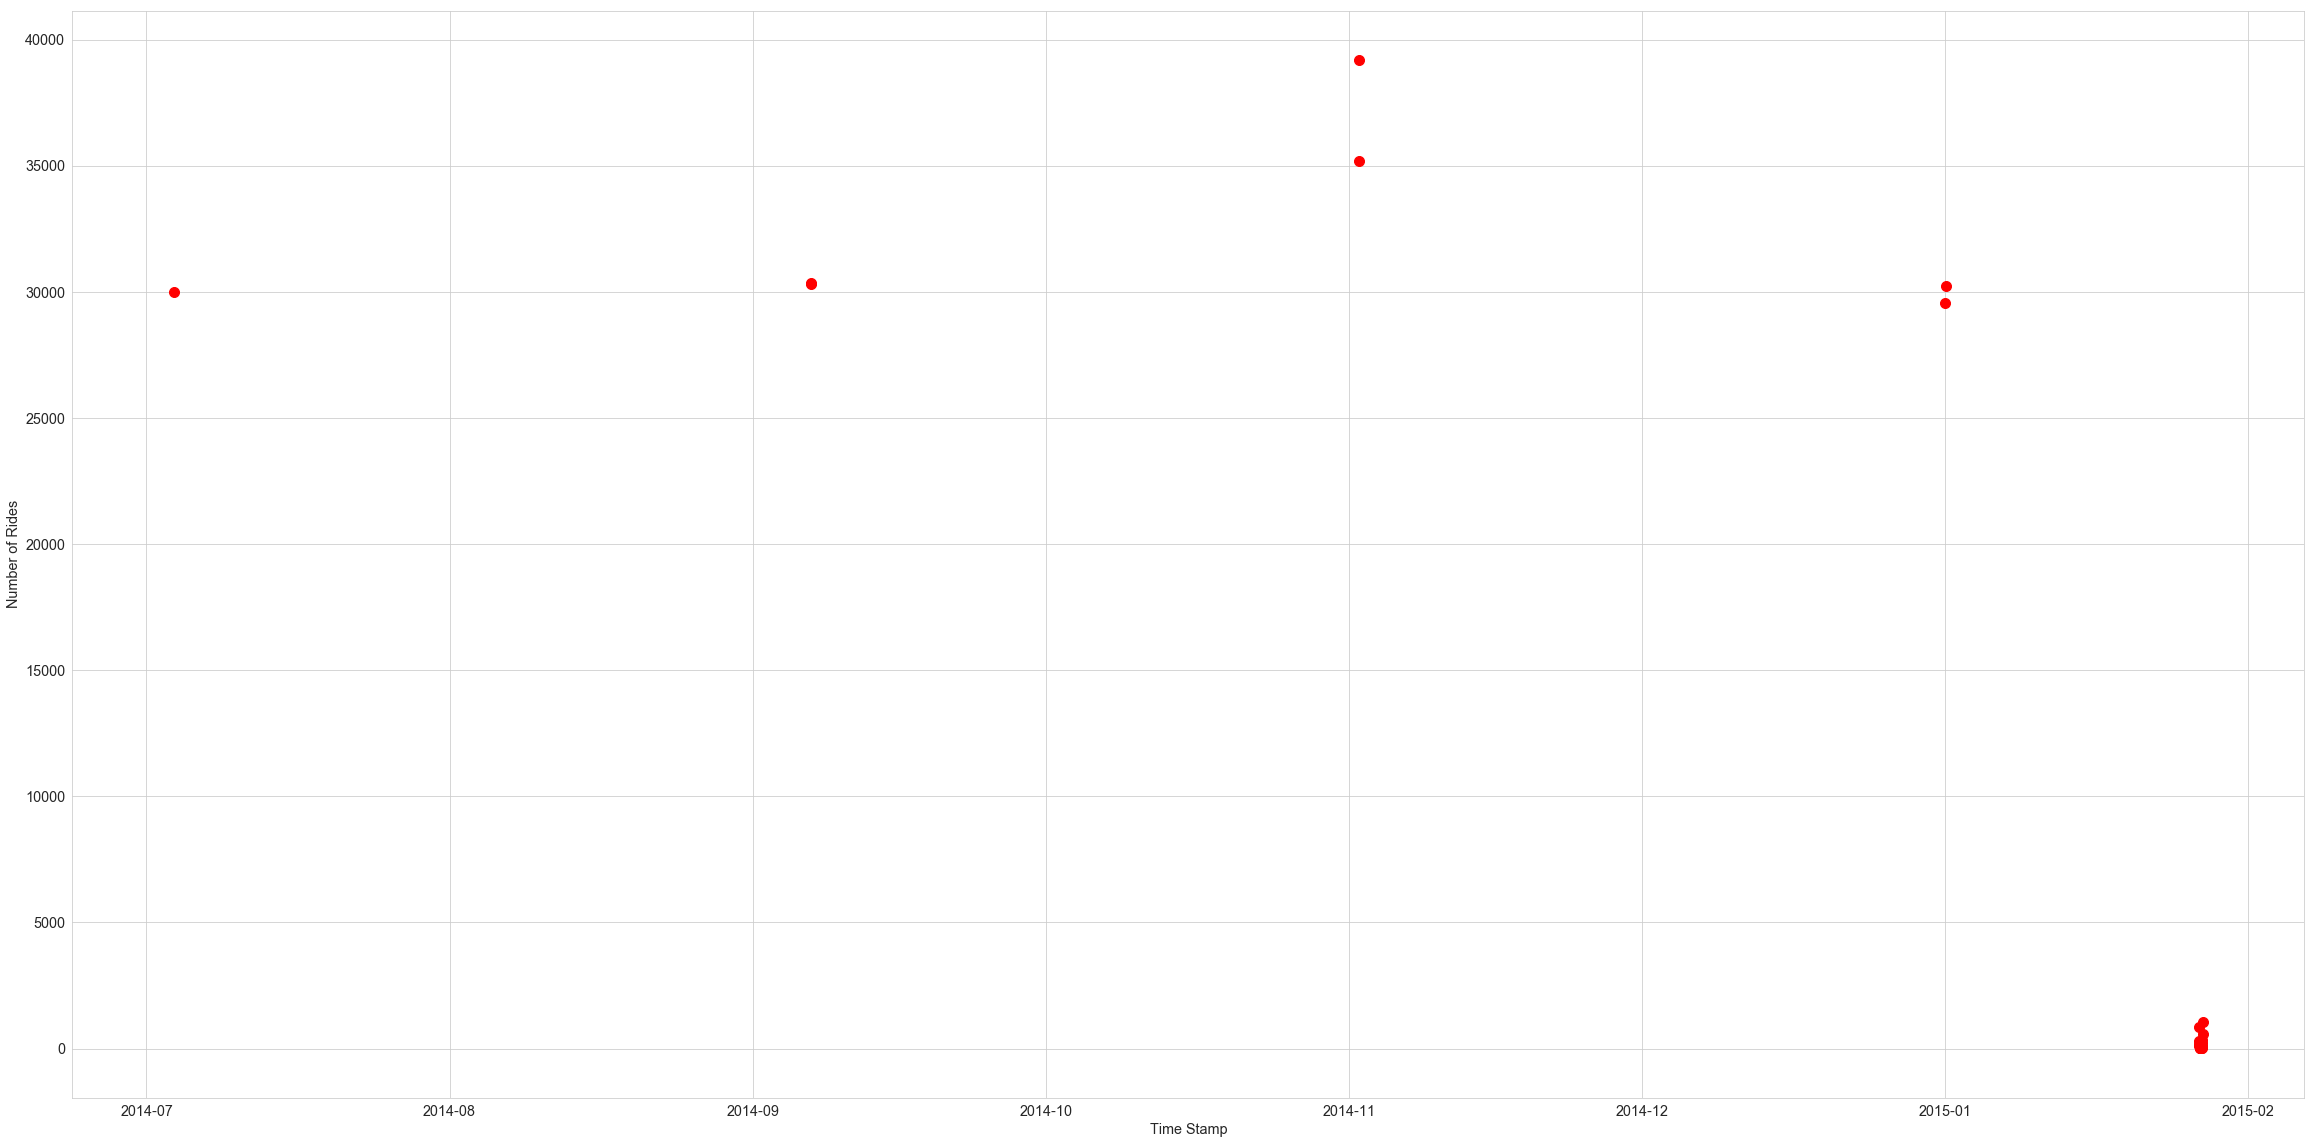

In [24]:
f1 = plt.figure(figsize=(40,20))
# df['rides'].plot()
rows = df[df.anomaly.isin([1])].itertuples()
for row in rows:
    plt.plot(row[0], row[1], 'r.', markersize=20.0)
plt.xlabel("Time Stamp")
plt.ylabel("Number of Rides")
plt.show()
pp = PdfPages('nyc_taxi_data.pdf')
pp.savefig(f1)
pp.close()

Size of train: 6672
Size of test: 1440
Size of validation1: 528
Size of validation2: 1680
Total: 10320
Ratio of train: 0.646512
Ratio of test: 0.139535
Ratio of validation1: 0.051163
Ratio of validation2: 0.162791


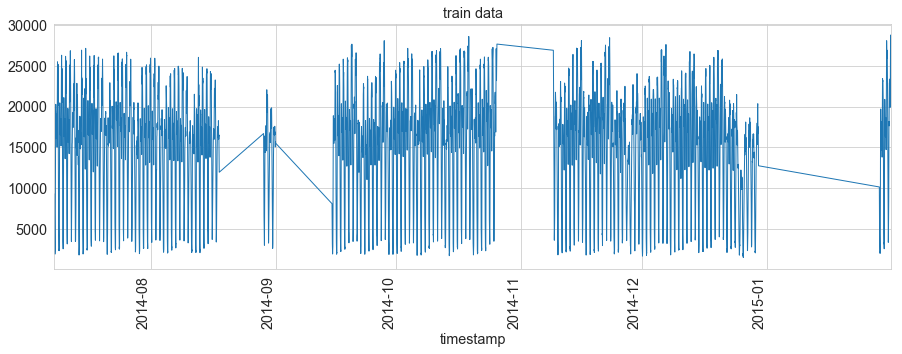

Pandas(Index=Timestamp('2015-01-01 00:30:00'), rides=29547, anomaly=1)
Pandas(Index=Timestamp('2015-01-01 01:00:00'), rides=30236, anomaly=1)
Pandas(Index=Timestamp('2015-01-26 22:30:00'), rides=866, anomaly=1)
Pandas(Index=Timestamp('2015-01-26 23:00:00'), rides=297, anomaly=1)
Pandas(Index=Timestamp('2015-01-26 23:30:00'), rides=189, anomaly=1)
Pandas(Index=Timestamp('2015-01-27 00:00:00'), rides=109, anomaly=1)
Pandas(Index=Timestamp('2015-01-27 00:30:00'), rides=80, anomaly=1)
Pandas(Index=Timestamp('2015-01-27 01:00:00'), rides=40, anomaly=1)
Pandas(Index=Timestamp('2015-01-27 01:30:00'), rides=39, anomaly=1)
Pandas(Index=Timestamp('2015-01-27 02:00:00'), rides=26, anomaly=1)
Pandas(Index=Timestamp('2015-01-27 02:30:00'), rides=32, anomaly=1)
Pandas(Index=Timestamp('2015-01-27 03:00:00'), rides=8, anomaly=1)
Pandas(Index=Timestamp('2015-01-27 03:30:00'), rides=11, anomaly=1)
Pandas(Index=Timestamp('2015-01-27 04:00:00'), rides=9, anomaly=1)
Pandas(Index=Timestamp('2015-01-27 04:30

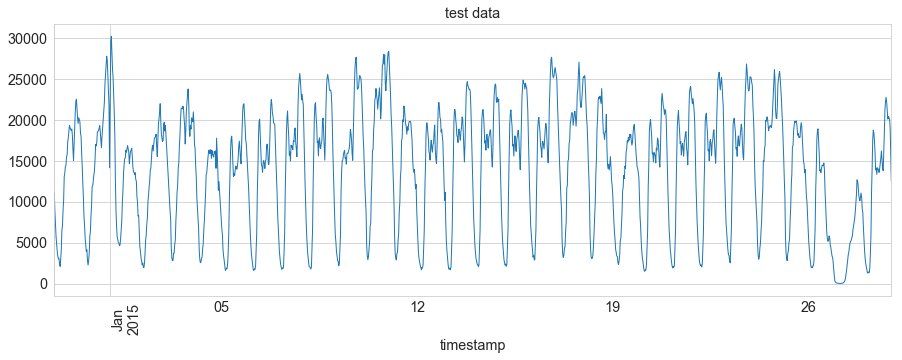

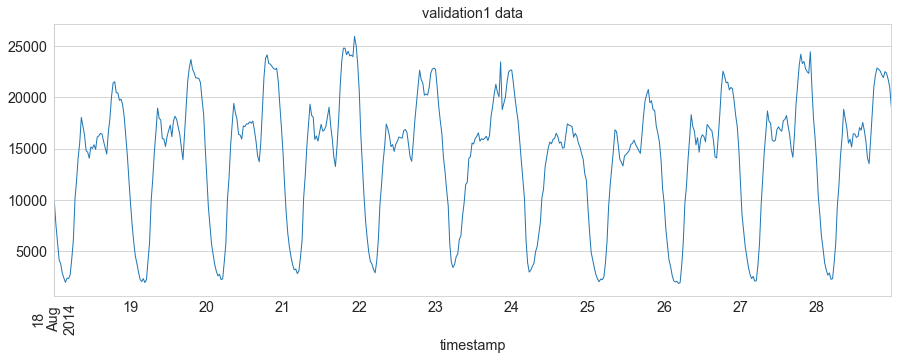

Pandas(Index=Timestamp('2014-07-03 19:00:00'), rides=29985, anomaly=1)
Pandas(Index=Timestamp('2014-09-06 22:30:00'), rides=30313, anomaly=1)
Pandas(Index=Timestamp('2014-09-06 23:00:00'), rides=30373, anomaly=1)
Pandas(Index=Timestamp('2014-11-02 01:00:00'), rides=39197, anomaly=1)
Pandas(Index=Timestamp('2014-11-02 01:30:00'), rides=35212, anomaly=1)


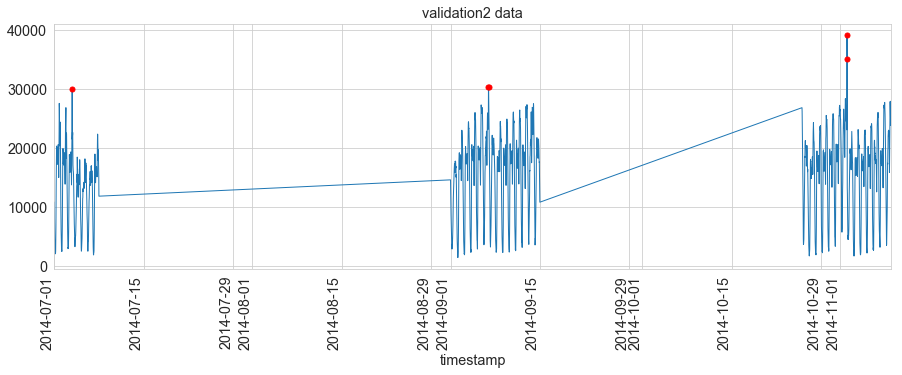

In [30]:
'''
Anomaly Dates: Jun 3, Sept 6, Nov 2, Jan 1, Jan 26-27
'''
# df_validation_prediction = pd.concat([df['2013-12-13'],df['2013-12-18':'2013-12-20']])
# df_test = pd.concat([df['2013-12-09':'2013-12-12'],df['2013-12-14':'2013-12-17']])
df_validation_prediction = df['2014-08-18':'2014-08-28']
df_test = df['2014-12-30':'2015-01-28']
df_validation_anomaly = pd.concat([df['2014-07-01':'2014-07-07'],df['2014-09-01':'2014-09-14'],df['2014-10-26':'2014-11-08']])
df_not_train = pd.concat([df_validation_prediction,df_validation_anomaly,df_test])
df_train = df[~df.isin(df_not_train)].dropna()

df_dict = {}
df_dict['train'] = df_train
df_dict['test'] = df_test
df_dict['validation1'] = df_validation_prediction
df_dict['validation2'] = df_validation_anomaly

count = 0
for key in df_dict:
    print("Size of %s: %d"%(key,df_dict[key].shape[0]))
    count += df_dict[key].shape[0]
print("Total: %d"%(count))

for key in df_dict:
    print("Ratio of %s: %f"%(key,float(df_dict[key].shape[0])/count))

    
for key in df_dict:
    df_tmp = df_dict[key]
    plt.figure()
    df_tmp['rides'].plot(figsize=(15,5))
    rows = df_tmp[df_tmp.anomaly.isin([1])].itertuples()
    for row in rows:
        print(row)
        plt.plot(row[0], row[1], 'r.', markersize=10.0)
    plt.xticks(rotation='vertical')
    plt.title("%s data"%(key))
    plt.show()

In [35]:
for key in df_dict:
    np.save("../resources/data/nyc-taxi/%s"%(key),df_dict[key])

In [36]:
## code below this not used

In [37]:
train = np.load("../resources/data/nyc-taxi/train.npy")
validation1 = np.load("../resources/data/nyc-taxi/validation1.npy")
validation2 = np.load("../resources/data/nyc-taxi/validation2.npy")
test = np.load("../resources/data/nyc-taxi/test.npy")
test_orig = test

In [14]:
print(sum(train[:,1]))
print(sum(validation1[:,1]))
print(sum(validation2[:,1]))
print(sum(test[:,1]))

0.0
0.0
2.0
2.0


In [37]:


data_folder = "../resources/data/nab/nab_machine_temperature/"
train = np.load(data_folder+"train.npy")
validation1 = np.load(data_folder+"validation1.npy")
validation2 = np.load(data_folder+"validation2.npy")
test = np.load(data_folder + "test.npy")


train,train_scaler = standardize(train[:,0])
validation1,validation1_scaler = standardize(validation1[:,0])
validation2_labels = validation2[:,1]
validation2,validation2_scaler = standardize(validation2[:,0])
test_labels = test[:,1]
test,test_scaler = standardize(test[:,0])

look_back = 5 
look_ahead = 3
X_train, y_train = prepare_seq2seq_data(train,look_back,look_ahead)
X_validation1, y_validation1 =  prepare_seq2seq_data(validation1,look_back,look_ahead)
X_validation2, y_validation2 =  prepare_seq2seq_data(validation2,look_back,look_ahead)
X_validation2_labels,y_validation2_labels = prepare_seq2seq_data(validation2_labels,look_back,look_ahead)
X_test, y_test = prepare_seq2seq_data(test,look_back,look_ahead)
X_test_labels,y_test_labels = prepare_seq2seq_data(test_labels,look_back,look_ahead)



NameError: name 'standardize' is not defined

In [126]:
#verify
print(test_orig[440:460])
X_test = test_scaler.inverse_transform(X_test)
y_test = test_scaler.inverse_transform(y_test)
print(X_test[440:460])
print(y_test[440:460])


[[ 50.66362073   0.        ]
 [ 49.52384528   0.        ]
 [ 51.39930184   0.        ]
 [ 49.8900245    0.        ]
 [ 49.62962429   0.        ]
 [ 50.7098265    0.        ]
 [ 49.57538032   0.        ]
 [ 50.68119402   0.        ]
 [ 50.96837729   0.        ]
 [ 51.65297521   0.        ]
 [ 50.11470329   0.        ]
 [ 50.19045678   0.        ]
 [ 49.6258836    0.        ]
 [ 49.78787651   0.        ]
 [ 51.94215975   0.        ]
 [ 50.0099379    0.        ]
 [ 50.18637613   0.        ]
 [ 51.96366361   0.        ]
 [ 51.92270289   0.        ]
 [ 52.17244522   0.        ]]


NameError: name 'test_scaler' is not defined

In [127]:
print(X_test_labels[440:460])
print(y_test_labels[440:460])

NameError: name 'X_test_labels' is not defined

In [128]:
plt.figure()
plt.plot(list(range(1,len(y_test)+1)),y_test[:,0])
anomalies = np.where(y_test_labels[:,0]==1)
# rows = y_test_labels
for row in anomalies:
    plt.plot(row, y_test[row,0], 'r.', markersize=10.0)
plt.show()

NameError: name 'y_test' is not defined

In [ ]:
plt.figure()
plt.plot(list(range(1,len(y_validation2)+1)),y_validation2[:,0])
anomalies = np.where(y_validation2_labels[:,0]==1)
# rows = y_test_labels
for row in anomalies:
    plt.plot(row, y_validation2[row,0], 'r.', markersize=10.0)
plt.show()

In [ ]:
plt.figure()
plt.plot(list(range(1,len(y_validation1)+1)),y_validation1[:,0])
plt.show()

### Part 2: Prediction Modeling
Use python scripts: *lstm_predictor.py , stateful_lstm_predictor.py*.

### Part 3: Anomaly Detection

In [38]:
data_folder = "../resources/data/nyc-taxi/"

In [39]:
#load training data
train_predictions = np.load(data_folder+"train_predictions.npy")
train_true = np.load(data_folder+"train_true.npy")
print(train_predictions.shape)
print(train_true.shape)


(6659, 1)
(6659,)


In [40]:
#load validation2 data
validation2_predictions = np.load(data_folder+"validation2_predictions.npy")
validation2_true = np.load(data_folder+"validation2_true.npy")
validation2_labels = np.load(data_folder+"validation2_labels.npy")
print(np.shape(validation2_predictions))
print(np.shape(validation2_true))
print(np.shape(validation2_labels))
validation2_labels = np.reshape(validation2_labels,[len(validation2_labels),np.shape(validation2_labels)[1]])
print(np.shape(validation2_labels))


(1667, 1)
(1667,)
(1667, 1, 1)
(1667, 1)


In [41]:
# load test data
test_predictions = np.load(data_folder+"test_predictions.npy")
test_true = np.load(data_folder+"test_true.npy")
test_labels = np.load(data_folder+"test_labels.npy")
print(np.shape(test_predictions))
print(np.shape(test_true))
test_labels = np.reshape(test_labels,[len(test_labels),np.shape(test_labels)[1]])
print(np.shape(test_labels))

(1427, 1)
(1427,)
(1427, 1)


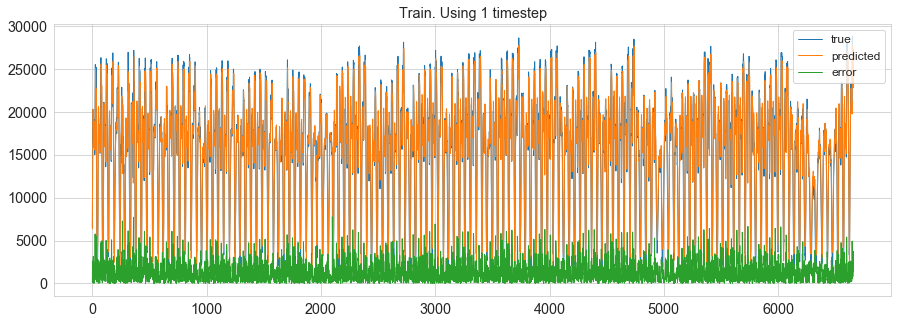

In [42]:
plt.figure(figsize=(15,5))
plt.plot(train_true,label='true')
plt.plot(train_predictions[:,0],label='predicted')
plt.plot(abs(train_true - train_predictions[:,0]),label='error')
plt.legend()
plt.title("Train. Using 1 timestep")
plt.show()

(6659, 1)


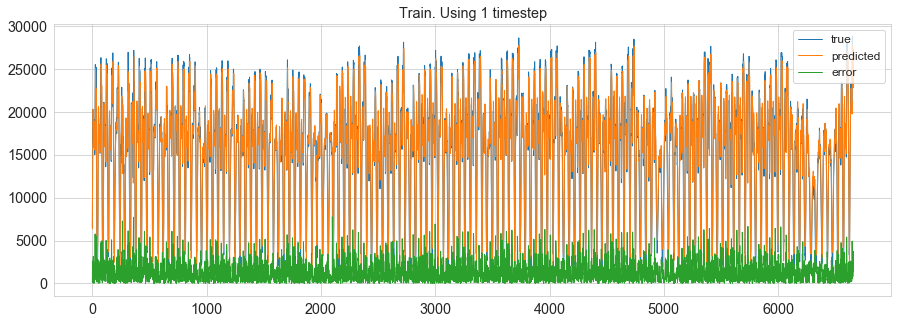

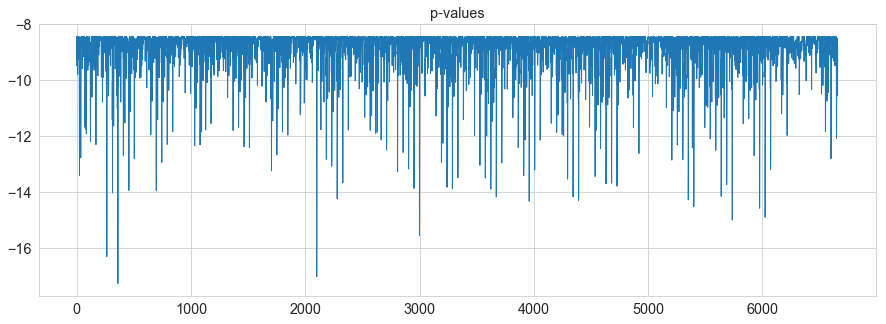

In [43]:
#error vectors
from scipy.stats import norm
from scipy.stats import multivariate_normal

train_error_vectors = np.zeros(np.shape(train_predictions))
n_cols = np.shape(train_predictions)[1]
for i in range(n_cols):
    train_error_vectors[:,i] =  train_true -train_predictions[:,i]

#ERROR DIMENSION
error_dimension = 1


train_error_vectors = train_error_vectors[:,0:error_dimension]
print(np.shape(train_error_vectors))
mean = np.mean(train_error_vectors)
std = np.std(train_error_vectors)
p_values= norm(loc=mean, scale=std).logpdf(train_error_vectors)

plt.figure(figsize=(15,5))
plt.plot(train_true,label='true')
plt.plot(train_predictions[:,0],label='predicted')
plt.plot(abs(train_true - train_predictions[:,0]),label='error')
plt.title("Train. Using 1 timestep")
plt.legend()

# plt.figure(figsize=(15,5))
# plt.plot(train_true,label='true')
# plt.plot(train_predictions[:,5],label='predicted')
# plt.plot(abs(train_true - train_predictions[:,5]),label='error')
# plt.title("Train. Using 6 timestep")
# plt.legend()


plt.figure(figsize=(15,5))
plt.plot(p_values)
plt.title("p-values")
plt.show()

train_errors_1 = train_true - train_predictions[:,0]

In [44]:
v2_error_vectors = np.zeros(np.shape(validation2_predictions))
for i in range(n_cols):
    v2_error_vectors[:,i] =  validation2_true -validation2_predictions[:,i]
v2_error_vectors = v2_error_vectors[:,0:error_dimension]
v2_p_values= norm(loc=mean, scale=std).logpdf(v2_error_vectors)
v2_true_anomalies = np.where(validation2_labels[:,0]==1)
print("Validation2. Number True Anomalies: %d"%(np.shape(v2_true_anomalies)[1]))
print("Validation2. Location of anomalies: %s"%(v2_true_anomalies))
print("validation2. True anomalies: %s"%(validation2_true[v2_true_anomalies]))
v2_thresholds =v2_p_values[v2_true_anomalies]
print("validation2. p-values at true anomalies: %s"%(v2_thresholds))


test_error_vectors = np.zeros(np.shape(test_predictions))

for i in range(n_cols):
    test_error_vectors[:,i] =  test_true -test_predictions[:,i]
test_error_vectors = test_error_vectors[:,0:error_dimension]
test_p_values= norm(loc=mean, scale=std).logpdf(test_error_vectors)
test_true_anomalies = np.where(test_labels[:,0]==1)
print("Test. Number True Anomalies in: %d"%(np.shape(test_true_anomalies)[1]))
print("Test. Location of anomalies: %s"%(test_true_anomalies))
print("Test. True anomalies: %s"%(test_true[test_true_anomalies]))
test_thresholds = test_p_values[test_true_anomalies]
print("Test. p-values at true anomalies: %s"%(test_thresholds))





Validation2. Number True Anomalies: 5
Validation2. Location of anomalies: [ 122  609  610 1334 1335]
validation2. True anomalies: [29985. 30313. 30373. 39197. 35212.]
validation2. p-values at true anomalies: [[-17.78124611]
 [-16.74800551]
 [-11.40759291]
 [-44.58318819]
 [-13.08291113]]
Test. Number True Anomalies in: 23
Test. Location of anomalies: [  85   86 1329 1330 1331 1332 1333 1334 1335 1336 1337 1338 1339 1340
 1341 1342 1343 1344 1345 1346 1347 1348 1349]
Test. True anomalies: [2.9547e+04 3.0236e+04 8.6600e+02 2.9700e+02 1.8900e+02 1.0900e+02
 8.0000e+01 4.0000e+01 3.9000e+01 2.6000e+01 3.2000e+01 8.0000e+00
 1.1000e+01 9.0000e+00 2.0000e+01 2.1000e+01 3.7000e+01 6.9000e+01
 1.0700e+02 2.1600e+02 3.3200e+02 5.7000e+02 1.0490e+03]
Test. p-values at true anomalies: [[-34.02897617]
 [-18.32551309]
 [ -9.6208659 ]
 [ -9.40038615]
 [ -8.9272218 ]
 [ -8.74659851]
 [ -8.74817951]
 [ -8.90931136]
 [ -9.14979023]
 [ -9.40308875]
 [ -9.55815915]
 [ -9.63433922]
 [ -9.59725891]
 [ -9.5

(array([ 122,  609,  610, 1334, 1335]),)


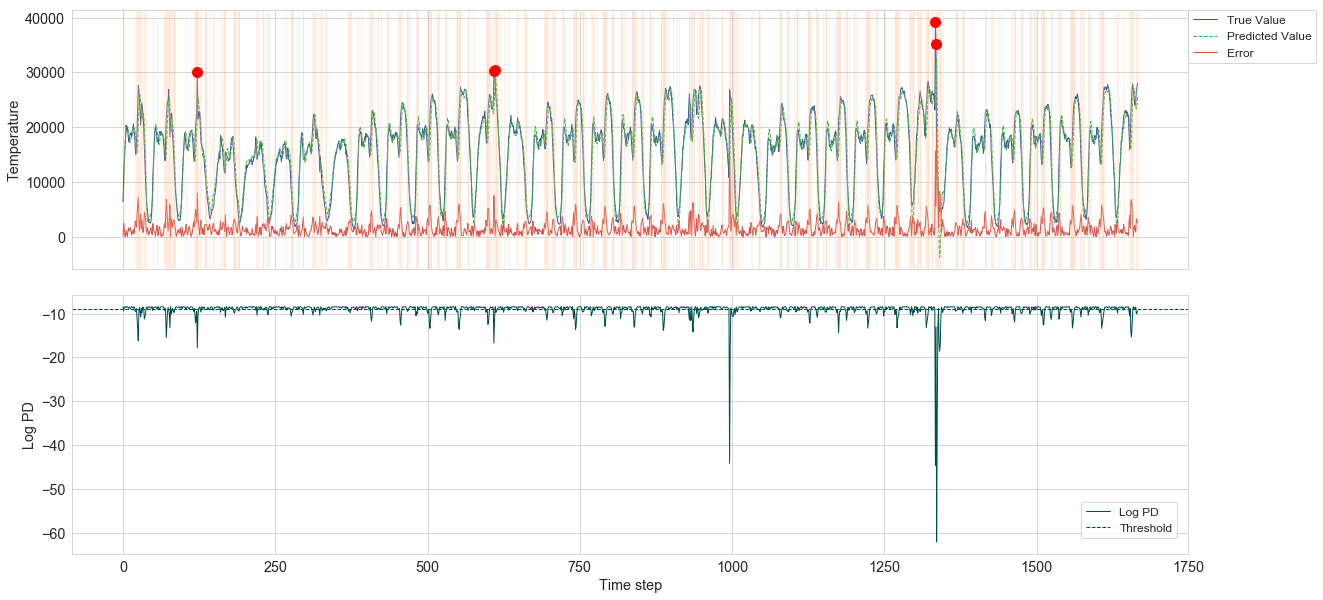

In [45]:
threshold_v2 = -9
v2_below_threshold = np.where(v2_p_values <= threshold_v2)

f = plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=0.1)

ax1 = plt.subplot(211)
ax1.plot(validation2_true,label='True Value',color=sns.xkcd_rgb["denim blue"])
ax1.plot(validation2_predictions[:,0],ls ='dashed',label='Predicted Value',color=sns.xkcd_rgb["medium green"])
ax1.plot(abs(validation2_true - validation2_predictions[:,0]),label='Error',color=sns.xkcd_rgb["pale red"])
for column in v2_below_threshold[0]:
    ax1.axvline(x=column,color=sns.xkcd_rgb["peach"],alpha=.2)
# ax1.axvline(x= v2_true_anomalies[0][0],color=sns.xkcd_rgb["peach"],alpha=.8)
for row in v2_true_anomalies:
    print(v2_true_anomalies)
    ax1.plot(row, validation2_true[row], 'r.', markersize=20.0)

plt.ylabel("Temperature")
ax1.legend(bbox_to_anchor=(1,1),borderaxespad=0.,frameon=True)
#plt.title("Validation2. Using 1 timestep")

ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(v2_p_values,label='Log PD',color=sns.xkcd_rgb["dark teal"])
#plt.title("Validation2 p-values")
ax2.axhline(y=threshold_v2,ls='dashed',label='Threshold',color=sns.xkcd_rgb["dark teal"],)
ax2.legend(bbox_to_anchor=(.99, 0.2), borderaxespad=0.,frameon=True)
plt.ylabel("Log PD")
#Set up the xlabel and xtick
#xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels()
xticklabels = ax1.get_xticklabels()
plt.setp(xticklabels, visible=False)
plt.xlabel("Time step")
plt.show()

pp = PdfPages('machine_temp_v2.pdf')
pp.savefig(f)
pp.close()

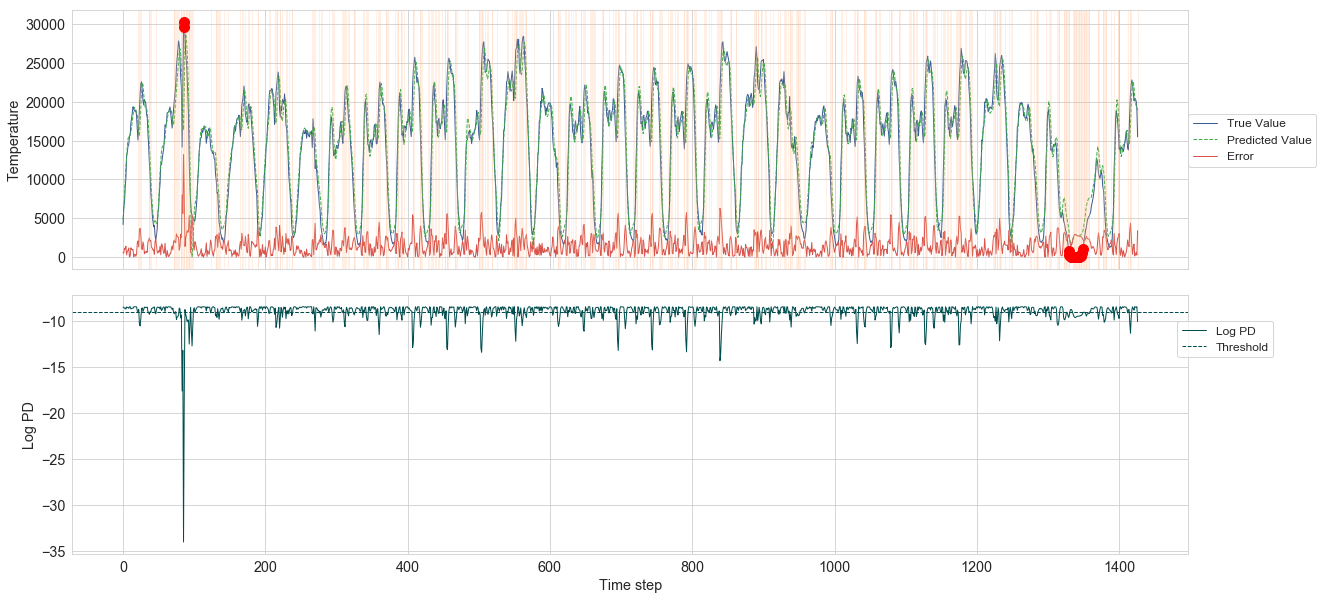

In [46]:

test_below_threshold = np.where(test_p_values <= threshold_v2)

f = plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=0.1)

ax1 = plt.subplot(211)
ax1.plot(test_true,label='True Value',color=sns.xkcd_rgb["denim blue"])
ax1.plot(test_predictions[:,0],ls ='dashed',label='Predicted Value',color=sns.xkcd_rgb["medium green"])
ax1.plot(abs(test_true - test_predictions[:,0]),label='Error',color=sns.xkcd_rgb["pale red"])
for column in test_below_threshold[0]:
    ax1.axvline(x=column,color=sns.xkcd_rgb["peach"],alpha=.2)
for row in test_true_anomalies:
    ax1.plot(row, test_true[row], 'r.', markersize=20.0)
plt.ylabel("Temperature")
ax1.legend(bbox_to_anchor=(1,.6),borderaxespad=0.,frameon=True)
#plt.title("test. Using 1 timestep")

ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(test_p_values,label='Log PD',color=sns.xkcd_rgb["dark teal"])
#plt.title("test p-values")
ax2.axhline(y=threshold_v2,ls='dashed',label='Threshold',color=sns.xkcd_rgb["dark teal"],)
ax2.legend(bbox_to_anchor=(.99, .9), borderaxespad=0.,frameon=True)
plt.ylabel("Log PD")
#Set up the xlabel and xtick
#xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels()
xticklabels = ax1.get_xticklabels()
plt.setp(xticklabels, visible=False)
plt.xlabel("Time step")
plt.show()

pp = PdfPages('machine_temp_test.pdf')
pp.savefig(f)
pp.close()
# plt.figure(figsize=(15,5))
# plt.plot(test_true,label='true')
# plt.plot(test_predictions[:,0],label='predicted')
# plt.plot(abs(test_true - test_predictions[:,0]),label='error')
# for row in test_true_anomalies:
#     plt.plot(row, test_true[row], 'r.', markersize=20.0)
# for column in test_below_threshold[0]:
#     plt.axvline(x=column,color=sns.xkcd_rgb["peach"],alpha=0.1)
# plt.legend()
# plt.title("Test. Using 1 timestep")
# plt.show()

# plt.figure(figsize=(15,5))
# plt.plot(test_p_values)
# plt.title("test p-values")
# plt.axhline(y=threshold_v2,ls='dashed',label='Threshold',color=sns.xkcd_rgb["dark teal"])
# plt.show()

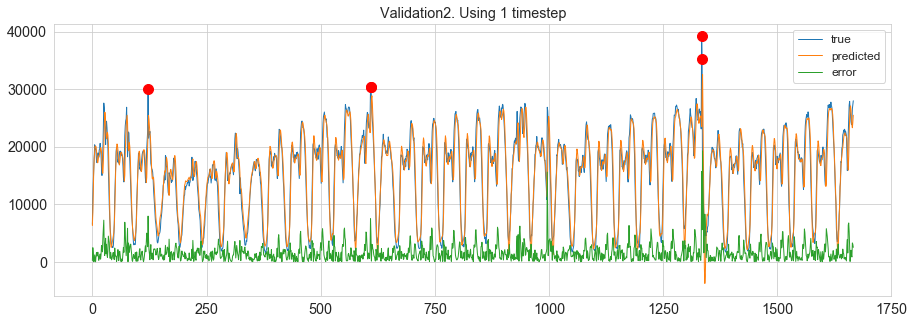

IndexError: index 11 is out of bounds for axis 1 with size 1

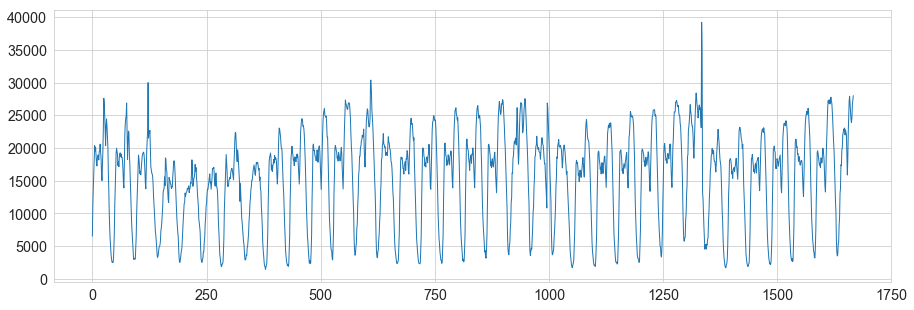

In [47]:
plt.figure(figsize=(15,5))
plt.plot(validation2_true,label='true')
plt.plot(validation2_predictions[:,0],label='predicted')
plt.plot(abs(validation2_true - validation2_predictions[:,0]),label='error')
for row in v2_true_anomalies:
    plt.plot(row, validation2_true[row], 'r.', markersize=20.0)
plt.legend()
plt.title("Validation2. Using 1 timestep")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(validation2_true,label='true')
plt.plot(validation2_predictions[:,11],label='predicted')
plt.plot(abs(validation2_true - validation2_predictions[:,11]),label='error')
for row in v2_true_anomalies:
    plt.plot(row, validation2_true[row], 'r.', markersize=20.0)
plt.legend()
plt.title("Validation2. Using 12 timestep")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(test_true,label='true')
plt.plot(test_predictions[:,0],label='predicted')
plt.plot(abs(test_true - test_predictions[:,0]),label='error')
for row in test_true_anomalies:
    plt.plot(row, test_true[row], 'r.', markersize=20.0)
plt.legend()
plt.title("Test. Using 1 timestep")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(test_true,label='true')
plt.plot(test_predictions[:,11],label='predicted')
plt.plot(abs(test_true - test_predictions[:,11]),label='error')
for row in test_true_anomalies:
    plt.plot(row, test_true[row], 'r.', markersize=20.0)
plt.legend()
plt.title("Test. Using 12 timestep")
plt.show()


Candidate Thresholds: [-40, -45, -50]


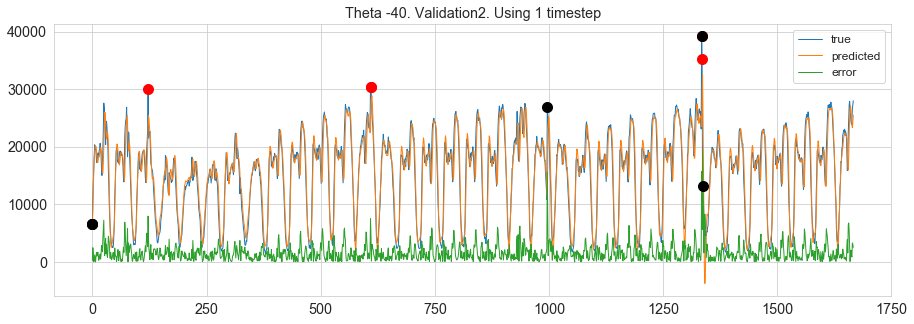

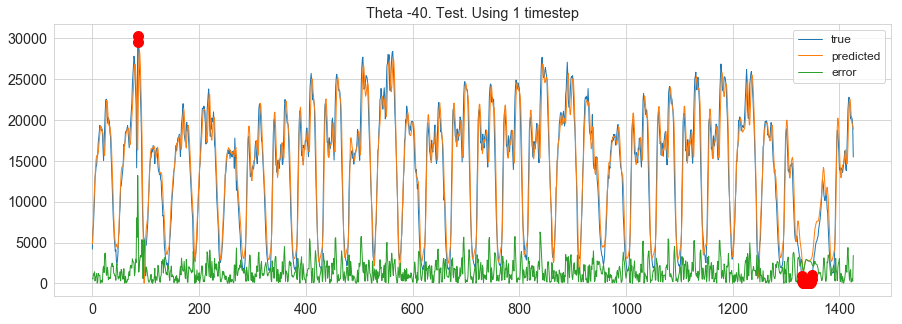

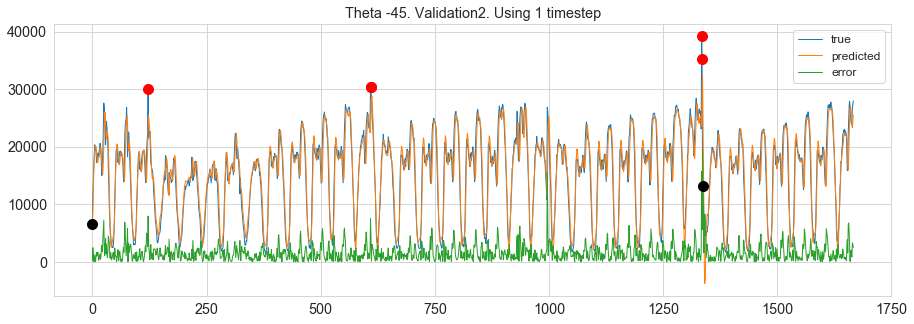

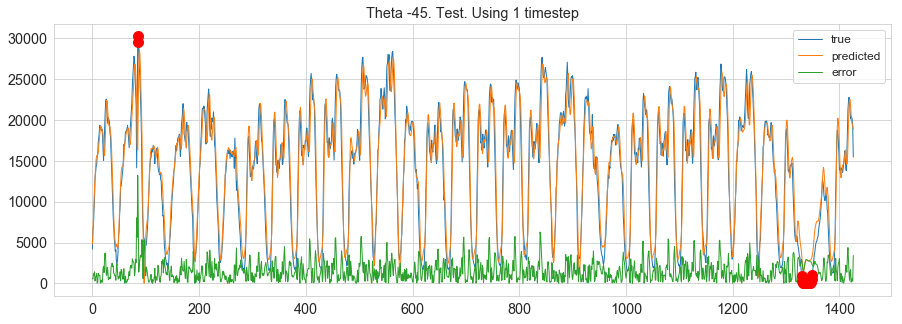

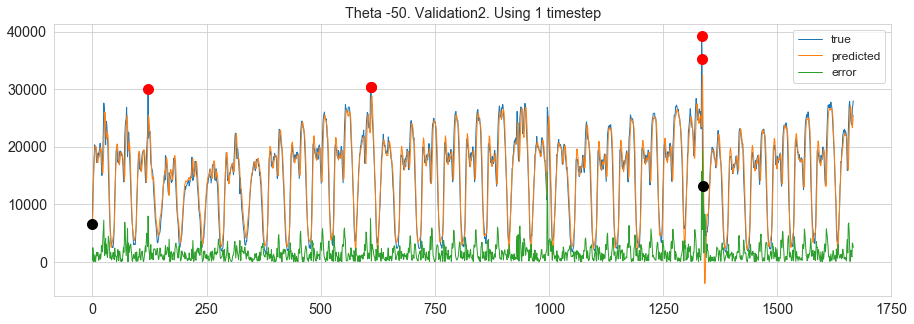

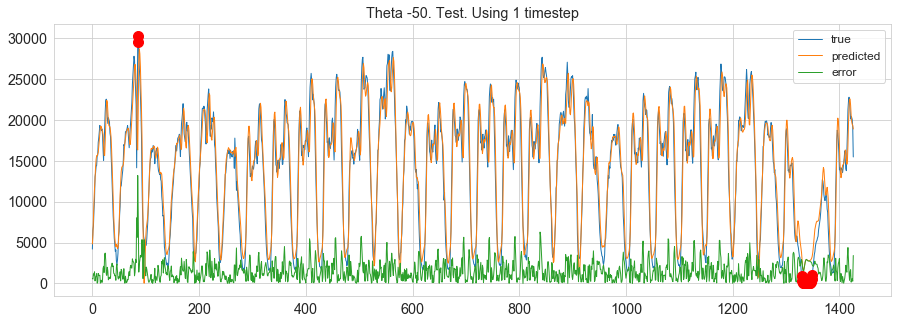

In [48]:
#thresholds = np.append(v2_thresholds,test_thresholds)

#thresholds =v2_thresholds
thresholds =[-40,-45,-50]
print()
print("Candidate Thresholds: %s"%(thresholds))


for i in thresholds:
    theta= i
    test_potential_anomalies = np.where(test_p_values <= theta)
    v2_potential_anomalies = np.where(v2_p_values <= theta)
    plt.figure(figsize=(15,5))
    plt.plot(validation2_true,label='true')
    plt.plot(validation2_predictions[:,0],label='predicted')
    plt.plot(abs(validation2_true - validation2_predictions[:,0]),label='error')
    for row in v2_true_anomalies:
        plt.plot(row, validation2_true[row], 'r.', markersize=20.0)
    for row in v2_potential_anomalies:
        plt.plot(row, validation2_true[row], 'k.', markersize=20.0)
    plt.legend()
    plt.title("Theta %s. Validation2. Using 1 timestep"%(i))
    plt.show()

    plt.figure(figsize=(15,5))
    plt.plot(test_true,label='true')
    plt.plot(test_predictions[:,0],label='predicted')
    plt.plot(abs(test_true - test_predictions[:,0]),label='error')
    for row in test_true_anomalies:
        plt.plot(row, test_true[row], 'r.', markersize=20.0)
    for row in test_potential_anomalies:
        plt.plot(row, test_true[row], 'k.', markersize=20.0)
    plt.legend()
    plt.title("Theta %s. Test. Using 1 timestep"%(i))
    plt.show()





In [49]:
theta= -50
test_predicted_anomalies = test_p_values <= theta
v2_predicted_anomalies = [1 if x <= theta else 0 for x in v2_p_values]
print(np.shape(validation2_labels))
print(fbeta_score(validation2_labels[:,0],v2_predicted_anomalies,pos_label=0, average='binary', beta=.5))
print() 

(1667, 1)
0.9974777804467932



(6659, 1)
[-76.43614291]
()
[2.12558111e-04 7.53318796e-05 1.86513086e-04 ... 5.85020553e-05
 2.58126157e-05 1.52397128e-04]
(6659,)


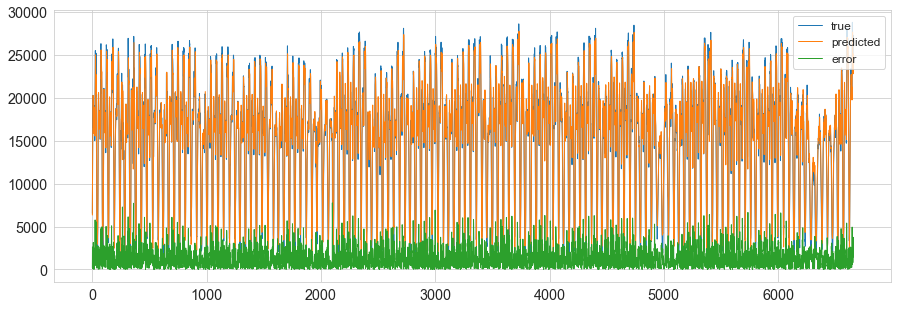

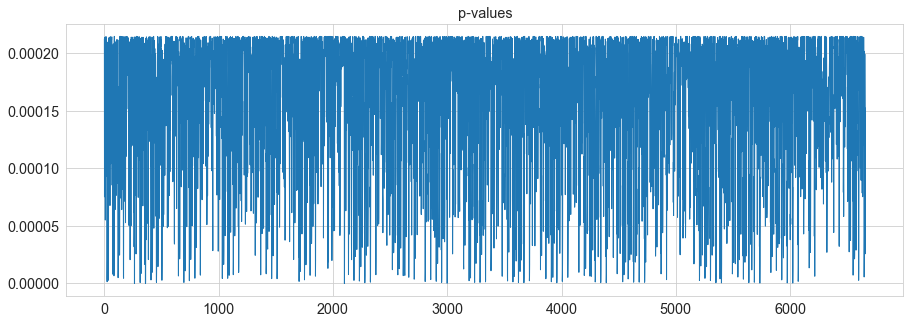

In [50]:
#error vectors
from scipy.stats import norm
from scipy.stats import multivariate_normal

train_error_vectors = np.zeros(np.shape(train_predictions))
for i in range(n_cols):
    train_error_vectors[:,i] =  train_true -train_predictions[:,i]
# print validation2_predictions[100:102]
# print validation2_true[100:102]
# print v2_error_vectors[100:102]
print(np.shape(train_error_vectors))
mean = np.mean(train_error_vectors, axis=0)
print(mean)
cov = np.cov(train_error_vectors,rowvar=False)
print(np.shape(cov))
p_values= multivariate_normal.pdf(train_error_vectors,mean,cov)
print(p_values)
print(np.shape(p_values))

plt.figure(figsize=(15,5))
plt.plot(train_true,label='true')
plt.plot(train_predictions[:,0],label='predicted')
plt.plot(abs(train_true - train_predictions[:,0]),label='error')
plt.legend()


plt.figure(figsize=(15,5))
plt.plot(p_values)
plt.title("p-values")
plt.show()

In [51]:
print(validation2_predictions[100])
print(validation2_true[100])

[16573.914]
16778.0


In [52]:
print(validation2_predictions[100] - validation2_true[100])

[-204.08594]


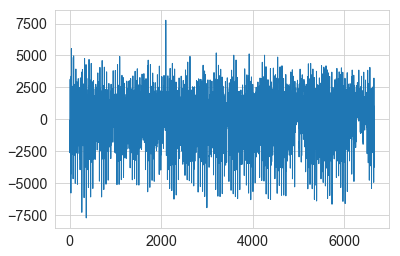

In [53]:
#using prediction intervals
#use first timestep
from scipy.stats import t
p = 95
alpha = (100-p)/100

train_errors = train_predictions[:,0] - train_true
n = np.shape(train_errors)[0]
s =  np.std(train_errors)
plt.plot(train_errors)
plt.show()
